# Name Evaluation

This document evaluates a list of American names published by the Social Security Administration.

[SSA data taken from here](https://rstudio-pubs-static.s3.amazonaws.com/24678_8234c801b4134f2cb32d8077f6cd75a2.html). Phonetic dictionary from CMU Sphinx project. [Scrabble dictionary from here](https://github.com/adrielklein/scrabble-word-finder). [Biblical names from here](https://github.com/SuzanaK/biblical_dictionary).

In [16]:
people_we_know = {
}

block_list = {
}.union(
    people_we_know
)

cool_male_names = {
    'Arthur', 'Chess', 'Key', 'Less', 'Echo', 'Tron', 'Kermit', 'Shingo', 'Gray', 'Moss', 'Lorne', 'Tin', 'Merlin',
}

cool_lady_names = {
    'Leidy', 'Chess', 'Twig', 'Ada', 'Luma', 'Lua', 'Elia', 'Alice', 'Rita', 'June', 'Lina', 'Amelia', 'Regan', 
}

In [22]:
# Read the list of all names since 1880 from the SSA dataset
from os import listdir
from os.path import isfile, join
yob_file_list = [f for f in listdir("ssa") if isfile(join("ssa", f)) and f.startswith("yob")]

import csv
year_name_frequency = {}
year_population = {}
gender_year_name_frequency = { 'M': {}, 'F': {} }
for file_name in yob_file_list:
    year = int(file_name[3:7])
    year_name_frequency[year] = {}
    gender_year_name_frequency['M'][year] = {}
    gender_year_name_frequency['F'][year] = {}
    with open(join("ssa", file_name)) as content:
        csvReader = csv.reader(content)
        for row in csvReader:
            year_name_frequency[year][row[0]] = year_name_frequency[year].get(row[0], 0) + int(row[2])
            gender_year_name_frequency[row[1]][year][row[0]] = int(row[2])
            if year not in year_population:
                year_population[year] = 0
            year_population[year] +=  int(row[2])

In [23]:
# Read a phonetic dictionary
phonetic_dictionary = {}
with open("cmudict/cmudict.dict") as file:
    for line in file:
       list = line.split('#')[0].split()
       phonetic_dictionary[str(list[0])] = list[1::]

In [24]:
# Read a dictionary of english words
# Words from https://github.com/adrielklein/scrabble-word-finder
english_dictionary = set()
with open("twl06.txt") as file:
    for line in file:
       english_dictionary.add(line.strip())

In [25]:
# Read a dictionary of biblical names
# Words from https://github.com/SuzanaK/biblical_dictionary
biblical_names = set()
with open("biblical_names_in_wordnet.txt") as file:
    for line in file:
       biblical_names.add(line.strip())

In [38]:
# Get an all-time frequency map 
name_frequency = {};
for year in year_name_frequency.keys():
    for name in year_name_frequency[year].keys():
        name_frequency[name] = name_frequency.get(name, 0) + year_name_frequency[year][name]
sorted_name_frequency = sorted(name_frequency.items(), key=lambda kv: kv[1])[::-1]

# Get frequency for each name by gender
gender_name_frequency = { 'M': {}, 'F': {} }
for gender in gender_year_name_frequency.keys():
    for year in gender_year_name_frequency[gender].keys():
        for name in gender_year_name_frequency[gender][year].keys():
            gender_name_frequency[gender][name] = gender_name_frequency[gender].get(name, 0) + gender_year_name_frequency[gender][year][name]

# Get a frequency rank overall
name_rank = {};
i = 0
for pair in sorted_name_frequency:
    name_rank[pair[0]] = i
    i = i + 1

# Create a map from name to a graph of frequency by year
name_year_frequency = {};
name_year_percentage = {};
for year in year_name_frequency:
    for name in year_name_frequency[year]:
        if name not in name_year_frequency:
            name_year_frequency[name] = {}
        name_year_frequency[name][year] = year_name_frequency[year][name]
        if name not in name_year_percentage:
            name_year_percentage[name] = {}
        name_year_percentage[name][year] = 100.0 * name_year_frequency[name][year] / year_population[year]

name_year_rank = {};
for year in name_year_percentage:
    name_year_rank[year] = {}
    i = 0
    for pair in sorted(name_year_percentage[year].items(), key=lambda kv: kv[1])[::-1]:
        name_year_rank[year][pair[0]] = i
        i = i + 1       
    
# In what year was the name most popular
name_peak_year = {};
for name in name_year_frequency:
    name_peak_year[name] = sorted(name_year_rank[name].items(), key=lambda kv: kv[1])[::-1][0][0]

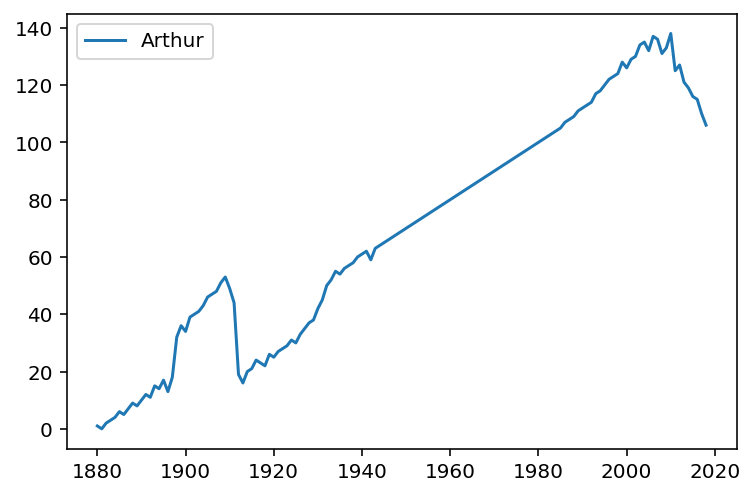

In [39]:
import matplotlib.pyplot as plt
for name in ['Arthur']:
    if name in name_year_rank:
        x, y = zip(*sorted(name_year_rank[name].items()))
        plt.plot(x, y, label=name)
        plt.legend();
plt.show();

In [41]:
# Normalize a name by it's pronunciation
def normalize_pronunciation(name):
    if name.lower() in phonetic_dictionary:
        return "-".join(phonetic_dictionary[name.lower()])
    return "-"

# Map names to their phonetic length
name_length = {}
for name in name_frequency:
    if name.lower() in phonetic_dictionary:
        name_length[name] = len(phonetic_dictionary[name.lower()])
# sorted_name_length = sorted(name_length.items(), key=lambda kv: kv[1])[::-1]
# sorted_name_length[:5]

# Map a normalized name to its homonyms
name_homonyms = {}
for name in name_frequency:
    normal = normalize_pronunciation(name)
    if normal not in name_homonyms:
        name_homonyms[normal] = [];
    name_homonyms[normal].append(name)

# Return True if there are no homonyms or if the given name is the
# most popular among all known homonyms. This is useful for
# filtering out unnecessary homonyms.
def isMostFrequentHomonym(name):
    if name_features[name]['homonym_count'] < 2:
        return True
    return (name == sorted(
        name_features[name]['homonyms'],
        key=lambda name: name_features[name]['popularity_rank']
    )[0])

# Names with most homonyms
# sorted_name_homonym_count = sorted(name_homonyms.items(), key=lambda kv: len(kv[1]))[::-1]
# sorted_name_homonym_count[1::][:5]

In [42]:
name_features = {};
for name in name_frequency:
    
    homonyms = name_homonyms.get(normalize_pronunciation(name), []) if normalize_pronunciation(name) != '-' else []
    min_homonym_female_ratio = min(
        [1.0] + [item for item in map(lambda n: 1.0 * gender_name_frequency['F'].get(n, 0)/(gender_name_frequency['F'].get(n, 0) + gender_name_frequency['M'].get(n, 0)),
            name_homonyms.get(normalize_pronunciation(name), []) \
                if normalize_pronunciation(name) != '-' else []
        )]
    )
    max_homonym_female_ratio = max(
        [0.0] + [item for item in map(lambda n: 1.0 * gender_name_frequency['F'].get(n, 0)/(gender_name_frequency['F'].get(n, 0) + gender_name_frequency['M'].get(n, 0)),
            name_homonyms.get(normalize_pronunciation(name), []) \
                if normalize_pronunciation(name) != '-' else []
        )]
    )
    
    name_features[name] = {
        'peak_year': name_peak_year.get(name, 0),
        'phonetic': phonetic_dictionary.get(name.lower(), ''),
        'phoneme_count': len(phonetic_dictionary.get(name.lower(), '')),
        'homonyms': homonyms,
        'homonym_count': len(homonyms),
        'popularity_rank': name_rank.get(name, -1),
        'female_ratio': 1.0 * gender_name_frequency['F'].get(name, 0) / (gender_name_frequency['F'].get(name, 0) + gender_name_frequency['M'].get(name, 0)),
        'min_homonym_female_ratio': min_homonym_female_ratio,
        'max_homonym_female_ratio': max_homonym_female_ratio,
        'is_in_dictionary': name.lower() in english_dictionary,
        'is_block_listed': name in block_list,
        'is_reverse_in_dictionary': name.lower()[::-1] in english_dictionary,
        'is_biblical_name': name in biblical_names,
    }

In [46]:
# Warning: if we insist on having a phonetic spelling we'll miss out on names
#          that aren't in the phonetic dictionary.
criteria = lambda name, n: \
    not n['is_block_listed'] and \
    n['popularity_rank'] >= 0 and \
    n['popularity_rank'] <= 100000 and \
    n['peak_year'] >= 0 and n['peak_year'] <= 2009 and \
    n['homonym_count'] >= 0 and \
    n['female_ratio'] == 0.0 and \
    n['min_homonym_female_ratio'] >= 0.0 and n['max_homonym_female_ratio'] <= 0.0 and \
    n['phoneme_count'] > 0 and n['phoneme_count'] < 100 and \
    not n['is_biblical_name'] and name[0] == 'Y'  
#    n['phonetic'][-1] in {'V', 'Z'}
#    n['phonetic'][-2:] == ['D', 'OW0']
#    not n['is_in_english_dictionary'] and \
#    n['phonetic'][0] in {'D', 'M', 'N'} and \

# list = [item for item in name_features.items() if criteria(item[0], item[1])]

# import random
# [item[0] for item in random.sample(list, min(10, len(list)))]

In [52]:
max_peak_year = max(map(lambda p: p[1]['peak_year'], name_features.items()))
min_peak_year = min(map(lambda p: p[1]['peak_year'], name_features.items()))
max_popularity_rank = max(map(lambda p: p[1]['popularity_rank'], name_features.items()))
max_phoneme_count = max(map(lambda p: p[1]['phoneme_count'], name_features.items()))
max_homonym_count = max(map(lambda p: p[1]['homonym_count'], name_features.items()))

weights = {
    # Names that were most popular in 2018 get 1.0 and names that
    # peaked in popularity in 1880 get a score of 0.0.
    'peak_year_recency_ratio': 0.1,
    
    # 1.0 if the name peaked before 2010 or 0.0 if after.
    'is_peak_year_before_2010': 0.1,

    # 1.0 if the name peaked before 2005 or 0.0 if after.
    'is_peak_year_before_2005': 0.0,

    # 1.0 if the name peaked before 2000 or 0.0 if after.
    'is_peak_year_before_2000': 0.0,

    # 1.0 if the name peaked before 1982 or 0.0 if after.
    'is_peak_year_before_1982': 0.0,

    # 1.0 if the name peaked after 1948 or 0.0 if after.
    'is_peak_year_after_1948': 0.0,

    # The most popular name gets a score of 1.0 and the least 1.0.
    'popularity_rank_ratio': 0.0,

    # Names that aren't in the top n get a score of 1.0. Else 0.
    'is_not_too_popular': 0.0,
    
    # Names that are in the top n get a score of 1.0. Else 0.
    'is_popular_enough': 0.0,
    
    # Names that are only ever female get 1.0. Names that are only
    # male get 0.0
    'female_ratio': 0.0,
    
    # Names get 1.0 if they are less than 25% female, else 0.
    'female_ratio_cutoff_20': 0.1,
    
    # The maximum `female_ratio` score across all homonyms
    'max_homonym_female_ratio': 0.0,
    
    # The minimum `female_ratio` score across all homonyms
    'min_homonym_female_ratio': 0.0,
    
    # 1.0 if the name is block listed, else 0.0.
    'is_block_listed': -1.0,
    
    # 1.0 if the name is in the English dictionary, else 0.0
    'is_in_dictionary': 0.0,

    # 1.0 if the reverse of the name is in the English dictionary
    'is_reverse_in_dictionary': 0.0,
    
    # 1.0 if the name is in the phonetic dictionary
    'is_in_phonetic_dictionary': 0.0,
    
    # 1.0 if the name has the most phonemes
    'phoneme_count_ratio': 0.0,
    
    # 1.0 if the name has the most homonyms
    'homonym_count_ratio': 0.0,
    
    # 1.0 if the name is in a dictionary of biblical names, else 0
    'is_biblical_name': -1.0,
    
    'is_most_frequent_homonym': 0.1,
    
    # 1.0 if the name ends in ['S', 'AH0', 'N']
    'ends_in_son': -1.0
}

name_vector = {name: {
    'peak_year_recency_ratio': 1.0 - (1.0 * (max_peak_year - v['peak_year']) / min_peak_year),
    'is_peak_year_before_2010': 1.0 if v['peak_year'] < 2010 else 0.0,
    'is_peak_year_before_2005': 1.0 if v['peak_year'] < 2005 else 0.0,    
    'is_peak_year_before_2000': 1.0 if v['peak_year'] < 2000 else 0.0,    
    'is_peak_year_before_1982': 1.0 if v['peak_year'] < 1982 else 0.0,
    'is_peak_year_after_1948': 1.0 if v['peak_year'] > 1948 else 0.0,
    'popularity_rank_ratio': 1.0 - (1.0 * v['popularity_rank'] / max_popularity_rank),
    'is_not_too_popular': 1.0 if v['popularity_rank'] >= 400 else 0,
    'is_popular_enough': 1.0 if v['popularity_rank'] < 600 else 0,
    'female_ratio': v['female_ratio'],
    'female_ratio_cutoff_20': 1.0 if v['female_ratio'] <= 0.20 else 0.0,
    'max_homonym_female_ratio': v['max_homonym_female_ratio'],
    'min_homonym_female_ratio': v['min_homonym_female_ratio'],
    'is_block_listed': 1.0 if v['is_block_listed'] else 0.0,
    'is_in_dictionary': 1.0 if v['is_in_dictionary'] else 0.0,
    'is_reverse_in_dictionary': 1.0 if v['is_reverse_in_dictionary'] else 0.0,
    'is_in_phonetic_dictionary': 1.0 if not v['phoneme_count'] else 0.0,
    'phoneme_count_ratio': (1.0 * v['phoneme_count'] / max_phoneme_count),
    'homonym_count_ratio': (1.0 * v['homonym_count'] / max_homonym_count),
    'is_biblical_name': 1.0 if v['is_biblical_name'] else 0.0,
    'is_most_frequent_homonym': 1.0 if isMostFrequentHomonym(name) else 0.0,
    'ends_in_son': 1.0 if v['phonetic'][-3:] == ['S', 'AH0', 'N'] else 0.0
} for name, v in name_features.items()}

from functools import reduce
def score(name):
    return reduce(
        lambda s, feature: \
            s + (weights[feature] * name_vector[name][feature]),
        weights.keys(),
        0.0
    )

from random import sample
names = sorted(sample(name_vector.items(), len(name_vector.items())), key=lambda kv: score(kv[0]))[::-1]

# Filter out the least popular homonyms.
for name in [name[0] for name in filter(lambda kv: isMostFrequentHomonym(kv[0]), names)][:1000]:
    print(name)

Zyvion
Ladarrion
Degen
Tyjier
Serj
Fabrizzio
Yoandy
Ottoniel
Kreyton
Alekay
Jamaun
Jartavious
Coyote
Havik
Darwing
Malyki
Kavyn
Massen
Baelin
Corderro
Catrell
Kahlin
Yander
Meshal
Alp
Alyxzander
Krishav
Jeaven
Nahiem
Aceson
Salathiel
Taelan
Keadyn
Francis
Mohamadali
Ancelmo
Waymon
Xzaviar
Costello
Jaderian
Kamaehu
Jjesus
Aieden
Yeferson
Asif
Clement
Cherif
Rashawd
Reydon
Berish
Ekrem
Jainil
Acer
Jahkel
Kyro
Avantae
Melaki
Javiair
Zekariah
Khing
Jahkir
Saveion
Jymari
Oved
Arish
Leiam
Praxton
Raidan
Gabryal
Franklin
Johnanthan
Jacksin
Mingus
Lamere
Braxxton
Jaydenmatthew
Yoexis
Kinsler
Giobani
Jyquavious
Seangabriel
Camen
Kardin
Quinnell
Cadem
Illias
Jazayvion
Nuraz
Deyshaun
Shafin
Arka
Ezera
Winfred
Joshuacaleb
Tejan
Aken
Waiz
Johandry
Gagik
Kamelo
Benen
Dellan
Juvens
Demontez
Mijael
Xanti
Darel
Sujan
Khale
Hrishik
Jurem
Arseny
Murdoc
Jeshaiah
Jhaiden
Yermi
Aevin
Derien
Truen
Kelvontae
Brockman
Arthas
Sevion
Angeal
Ethanael
Jaythian
Travoris
Javanni
Moisses
Browning
Kahanuola
Casch
Yuvr

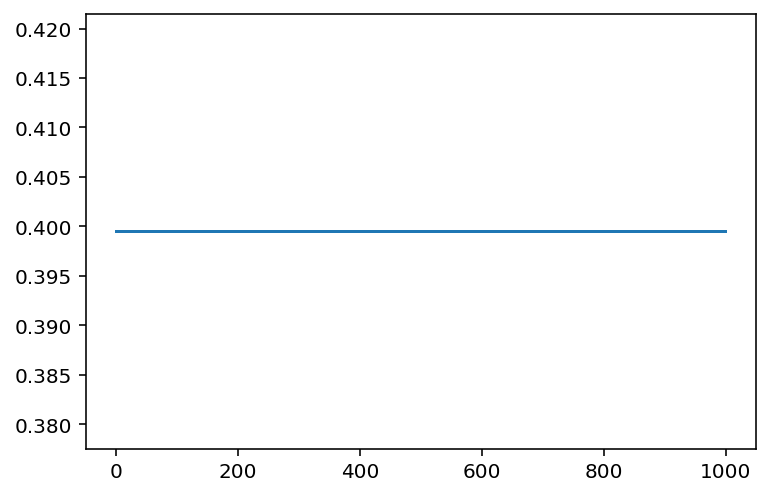

In [53]:
import matplotlib.pyplot as plt
plt.plot(
    [t[0] for t in enumerate(names)][:1000],
    [score(t[1][0]) for t in enumerate(names)][:1000],
    label=score
)
plt.show();

In [54]:
name_features['Arthur']

{'peak_year': 2010,
 'phonetic': ['AA1', 'R', 'TH', 'ER0'],
 'phoneme_count': 4,
 'homonyms': ['Arthur'],
 'homonym_count': 1,
 'popularity_rank': 119,
 'female_ratio': 0.006000368328278215,
 'min_homonym_female_ratio': 0.006000368328278215,
 'max_homonym_female_ratio': 0.006000368328278215,
 'is_in_dictionary': False,
 'is_block_listed': False,
 'is_reverse_in_dictionary': False,
 'is_biblical_name': False}

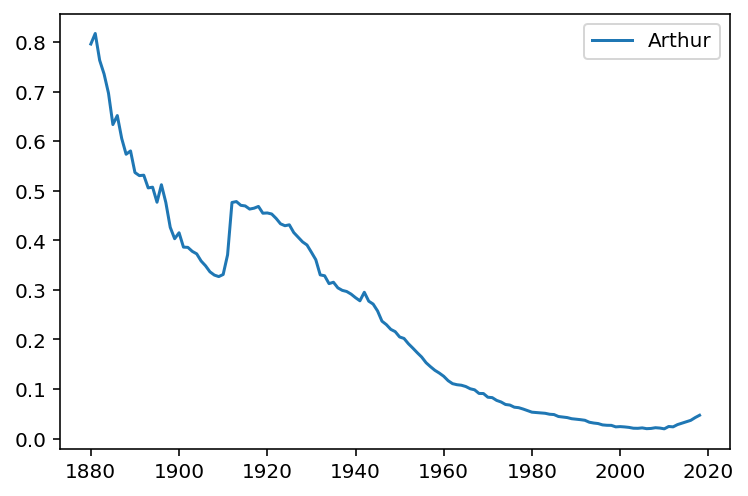

In [51]:
import matplotlib.pyplot as plt
for name in ['Arthur']:
    if name in name_year_percentage:
        x, y = zip(*sorted(name_year_percentage[name].items()))
        plt.plot(x, y, label=name)
        plt.legend();
plt.show();

In [17]:
name_features['Arthur']

{'peak_year': 1921,
 'phonetic': ['AA1', 'R', 'TH', 'ER0'],
 'phoneme_count': 4,
 'homonyms': ['Arthur'],
 'homonym_count': 1,
 'popularity_rank': 119,
 'female_ratio': 0.006000368328278215,
 'min_homonym_female_ratio': 0.006000368328278215,
 'max_homonym_female_ratio': 0.006000368328278215,
 'is_in_dictionary': False,
 'is_block_listed': False,
 'is_reverse_in_dictionary': False,
 'is_biblical_name': False}

In [15]:
# Read training data
ratings = {}
with open("./name_ratings.tsv") as file:
    for line in file:
        columns = line.split("\t")
        ratings[columns[0]] = {
            'Hannah': columns[1],
            'Andrew': columns[2]
        }